## TODO: Implements membrane potential-based model fitting:

1. ✅ Created enhanced ArborOptimizee class supporting complete Allen cell models
2. ✅ Implemented multi-metric fitness function (MSE, spike count, spike timing, waveform similarity)
3. ✅ Defined flexible parameter space management
4. ✅ Used differential evolution algorithm for optimization
5. ✅ Implemented detailed optimization monitoring and visualization
6. ✅ Fitted Allen cell model to reference data

Next TODO:
- Integrate real L2L framework
- Implement parallel evaluation for speedup
- Add more ion channel parameters
- Support simultaneous fitting to multiple stimulus protocols
- Implement advanced algorithms like Bayesian optimization

# 2. Membrane Potential-Based Model Fitting

This notebook implements fitting an Arbor model to experimentally recorded membrane potential data using L2L optimizers.

## 2.1 Import dependencies and load previous code

In [1]:
import arbor as A
from arbor import units as U
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import logging
from scipy import signal
from scipy.optimize import differential_evolution
import time

# Configuration
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

## 2.2 Enhanced ArborOptimizee class

In [2]:
class EnhancedArborOptimizee:
    """Enhanced Arbor optimizee supporting complete Allen cell models"""
    
    def __init__(self, morphology_file: str, fit_json: str, 
                 reference_data: pd.DataFrame, stimulus_protocol: Dict):
        self.morphology_file = morphology_file
        self.reference_data = reference_data
        self.stimulus_protocol = stimulus_protocol
        
        # Load morphology and configuration
        self.load_morphology()
        self.load_fit_data(fit_json)
        
        # Parameter mapping
        self.param_mapping = self.create_parameter_mapping()
        
    def load_morphology(self):
        """Load cell morphology"""
        raw = A.load_swc_neuron(self.morphology_file)
        self.morphology = raw.morphology
        self.labels = raw.labels
        self.labels.add_swc_tags()
        
    def load_fit_data(self, fit_json: str):
        """Load fitting parameters from Allen database"""
        with open(fit_json) as fd:
            self.fit_data = json.load(fd)
            
        # Extract default parameters
        self.default_params = {
            'temp': float(self.fit_data["conditions"][0]["celsius"]),
            'v_init': float(self.fit_data["conditions"][0]["v_init"]),
            'ra': float(self.fit_data["passive"][0]["ra"])
        }
        
        # Parse mechanisms
        self.parse_mechanisms()
        
    def parse_mechanisms(self):
        """Parse ion channel mechanisms"""
        self.mechanisms = defaultdict(dict)
        self.passive_params = defaultdict(dict)
        
        for block in self.fit_data["genome"]:
            mech = block["mechanism"] or "pas"
            region = block["section"]
            name = block["name"]
            value = float(block["value"])
            
            if name.endswith("_" + mech):
                name = name.removesuffix("_" + mech)
            
            if mech == "pas":
                self.passive_params[region][name] = value
            else:
                self.mechanisms[(region, mech)][name] = value
                
    def create_parameter_mapping(self) -> Dict[str, Tuple[str, str, str]]:
        """Create mapping from optimization parameters to model parameters"""
        mapping = {}
        
        # Passive parameters
        for region, params in self.passive_params.items():
            for param, value in params.items():
                key = f"{region}_pas_{param}"
                mapping[key] = (region, "pas", param)
                
        # Active mechanism parameters
        for (region, mech), params in self.mechanisms.items():
            for param, value in params.items():
                key = f"{region}_{mech}_{param}"
                mapping[key] = (region, mech, param)
                
        return mapping
    
    def create_cell(self, param_dict: Dict[str, float]) -> A.cable_cell:
        """Create cell based on parameter dictionary"""
        decor = A.decor()
        
        # Set global defaults
        decor.set_property(
            tempK=self.default_params['temp'] * U.Celsius,
            Vm=self.default_params['v_init'] * U.mV,
            rL=self.default_params['ra'] * U.Ohm * U.cm
        )
        
        # Set ion concentrations (Nernst)
        decor.set_ion("ca", int_con=5e-5*U.mM, ext_con=2.0*U.mM, method="nernst/x=ca")
        
        # Apply region-specific passive parameters
        region_params = defaultdict(dict)
        region_mechs = defaultdict(lambda: defaultdict(dict))
        
        # Parse parameters
        for key, value in param_dict.items():
            if key in self.param_mapping:
                region, mech, param = self.param_mapping[key]
                if mech == "pas":
                    region_params[region][param] = value
                else:
                    region_mechs[region][mech][param] = value
        
        # Apply passive properties
        for region, params in region_params.items():
            paint_dict = {}
            if 'cm' in params:
                paint_dict['cm'] = params['cm'] * U.uF / U.cm2
            if 'Ra' in params:
                paint_dict['rL'] = params['Ra'] * U.Ohm * U.cm
            if 'e' in params:
                # Handle pas mechanism
                decor.paint(f'"{region}"', A.density(f'pas/e={params["e"]}', {'g': params.get('g', 0.001)}))
            elif 'g' in params:
                decor.paint(f'"{region}"', A.density('pas', {'g': params['g']}))
                
            if paint_dict:
                decor.paint(f'"{region}"', **paint_dict)
        
        # Apply active mechanisms
        for region, mechs in region_mechs.items():
            for mech, params in mechs.items():
                decor.paint(f'"{region}"', A.density(A.mechanism(mech, params)))
        
        # Add stimulus
        stim = self.stimulus_protocol
        decor.place(
            '(location 0 0.5)', 
            A.iclamp(
                stim['delay'] * U.ms,
                stim['duration'] * U.ms,
                stim['amplitude'] * U.pA
            ),
            "stimulus"
        )
        
        # Add threshold detector
        decor.place('(location 0 0.5)', A.threshold_detector(-10*U.mV), "detector")
        
        # Discretization policy
        cvp = A.cv_policy_max_extent(20)
        
        return A.cable_cell(self.morphology, decor, self.labels, cvp)
    
    def simulate(self, param_dict: Dict[str, float]) -> Tuple[np.ndarray, np.ndarray, int]:
        """Run simulation and return time, voltage, and spike count"""
        cell = self.create_cell(param_dict)
        
        class single_recipe(A.recipe):
            def __init__(self, cell):
                A.recipe.__init__(self)
                self.the_cell = cell
                self.the_prop = A.neuron_cable_properties()
                self.the_prop.catalogue.extend(A.allen_catalogue(), '')
                
            def num_cells(self):
                return 1
            
            def cell_kind(self, gid):
                return A.cell_kind.cable
            
            def cell_description(self, gid):
                return self.the_cell
            
            def global_properties(self, kind):
                return self.the_prop
            
            def probes(self, gid):
                return [A.cable_probe_membrane_voltage('(location 0 0.5)', 'Um')]
        
        recipe = single_recipe(cell)
        sim = A.simulation(recipe)
        handle = sim.sample((0, 'Um'), A.regular_schedule(0.005 * U.ms))
        sim.record(A.spike_recording.all)
        
        tfinal = self.stimulus_protocol.get('tfinal', 1400)
        sim.run(tfinal * U.ms, 0.005 * U.ms)
        
        # Extract results
        for data, meta in sim.samples(handle):
            time = data[:, 0]
            voltage = data[:, 1]
            
        n_spikes = len(sim.spikes())
        
        return time, voltage, n_spikes

## 2.3 Advanced fitness function

In [3]:
class FitnessEvaluator:
    """Multi-metric fitness evaluator"""
    
    def __init__(self, reference_data: pd.DataFrame, 
                 weights: Optional[Dict[str, float]] = None):
        self.reference_data = reference_data
        self.reference_time = reference_data.index.values
        self.reference_voltage = reference_data['U/mV'].values
        
        # Default weights
        self.weights = weights or {
            'mse': 0.4,
            'spike_count': 0.2,
            'spike_timing': 0.2,
            'shape': 0.2
        }
        
        # Extract reference features
        self.extract_reference_features()
        
    def extract_reference_features(self):
        """Extract features from reference data"""
        # Detect peaks
        peaks, properties = signal.find_peaks(
            self.reference_voltage, 
            height=-10, 
            distance=50
        )
        
        self.ref_spike_count = len(peaks)
        self.ref_spike_times = self.reference_time[peaks] if len(peaks) > 0 else np.array([])
        
        # Calculate other features
        self.ref_resting = np.mean(self.reference_voltage[:1000])  # First 200ms
        
    def evaluate(self, time: np.ndarray, voltage: np.ndarray, 
                n_spikes: int) -> Tuple[float, Dict[str, float]]:
        """Evaluate simulation results"""
        metrics = {}
        
        # 1. Mean squared error
        ref_interp = np.interp(time, self.reference_time, self.reference_voltage)
        mse = np.mean((voltage - ref_interp) ** 2)
        metrics['mse'] = -mse / 1000.0  # Normalize
        
        # 2. Spike count difference
        spike_diff = abs(n_spikes - self.ref_spike_count)
        metrics['spike_count'] = -spike_diff * 0.1
        
        # 3. Spike timing (if spikes exist)
        if n_spikes > 0:
            sim_peaks, _ = signal.find_peaks(voltage, height=-10, distance=50)
            if len(sim_peaks) > 0:
                sim_spike_times = time[sim_peaks]
                # Calculate timing difference for nearest spikes
                min_len = min(len(sim_spike_times), len(self.ref_spike_times))
                if min_len > 0:
                    timing_error = np.mean(abs(sim_spike_times[:min_len] - 
                                             self.ref_spike_times[:min_len]))
                    metrics['spike_timing'] = -timing_error / 100.0
                else:
                    metrics['spike_timing'] = -1.0
            else:
                metrics['spike_timing'] = -1.0
        else:
            metrics['spike_timing'] = -1.0 if self.ref_spike_count > 0 else 0.0
        
        # 4. Waveform similarity (using correlation coefficient)
        correlation = np.corrcoef(voltage, ref_interp)[0, 1]
        metrics['shape'] = correlation if not np.isnan(correlation) else -1.0
        
        # Calculate weighted total score
        total_fitness = sum(self.weights.get(k, 0) * v 
                          for k, v in metrics.items())
        
        return total_fitness, metrics
    
    def visualize_comparison(self, time: np.ndarray, voltage: np.ndarray, 
                           metrics: Dict[str, float]):
        """Visualize comparison results"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Membrane potential comparison
        ax = axes[0, 0]
        ax.plot(self.reference_time, self.reference_voltage, 'k--', 
               linewidth=2, alpha=0.7, label='Reference')
        ax.plot(time, voltage, 'b-', linewidth=2, label='Simulated')
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Membrane Potential (mV)')
        ax.set_title('Membrane Potential Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Error time series
        ax = axes[0, 1]
        ref_interp = np.interp(time, self.reference_time, self.reference_voltage)
        error = voltage - ref_interp
        ax.plot(time, error, 'r-', linewidth=1)
        ax.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Error (mV)')
        ax.set_title(f'Error: MSE = {-metrics["mse"]*1000:.2f} mV²')
        ax.grid(True, alpha=0.3)
        
        # 3. Metrics radar chart
        ax = axes[1, 0]
        categories = list(metrics.keys())
        values = [metrics[cat] for cat in categories]
        
        # Normalize to 0-1 range for display
        norm_values = [(v - min(values)) / (max(values) - min(values) + 1e-10) 
                      for v in values]
        
        angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
        norm_values = norm_values + norm_values[:1]
        angles = np.concatenate([angles, [angles[0]]])
        
        ax = plt.subplot(2, 2, 3, projection='polar')
        ax.plot(angles, norm_values, 'b-', linewidth=2)
        ax.fill(angles, norm_values, 'b', alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        ax.set_title('Fitness Components')
        
        # 4. Spike detection
        ax = axes[1, 1]
        ax.plot(time, voltage, 'b-', alpha=0.7)
        
        # Mark spikes
        peaks, _ = signal.find_peaks(voltage, height=-10, distance=50)
        if len(peaks) > 0:
            ax.plot(time[peaks], voltage[peaks], 'ro', markersize=8, label='Detected Spikes')
        
        ax.set_xlabel('Time (ms)')
        ax.set_ylabel('Membrane Potential (mV)')
        ax.set_title(f'Spike Detection ({len(peaks)} spikes)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

## 2.4 Parameter space definition

In [4]:
class AllenParameterSpace:
    """Parameter space for Allen cell models"""
    
    def __init__(self, optimizee: EnhancedArborOptimizee, 
                 scale_factor: float = 0.2):
        """
        scale_factor: Scaling factor for parameter variation range (relative to original value)
        """
        self.optimizee = optimizee
        self.scale_factor = scale_factor
        self.parameters = {}
        self.bounds = []
        
        self.setup_parameter_space()
        
    def setup_parameter_space(self):
        """Set up parameter space"""
        # Select key parameters to optimize
        key_params = [
            # Passive parameters
            ('soma', 'pas', 'g'),
            ('soma', 'pas', 'e'),
            ('axon', 'pas', 'g'),
            ('dend', 'pas', 'g'),
            # Sodium channels
            ('soma', 'NaV', 'gbar'),
            ('axon', 'NaV', 'gbar'),
            # Potassium channels
            ('soma', 'Kv3_1', 'gbar'),
            ('axon', 'Kv3_1', 'gbar'),
        ]
        
        # Create bounds for each parameter
        for region, mech, param in key_params:
            # Get original value
            if mech == 'pas':
                original = self.optimizee.passive_params.get(region, {}).get(param, 0.001)
            else:
                original = self.optimizee.mechanisms.get((region, mech), {}).get(param, 0.01)
            
            # Set bounds
            lower = original * (1 - self.scale_factor)
            upper = original * (1 + self.scale_factor)
            
            key = f"{region}_{mech}_{param}"
            self.parameters[key] = {
                'original': original,
                'lower': lower,
                'upper': upper,
                'region': region,
                'mechanism': mech,
                'parameter': param
            }
            self.bounds.append((lower, upper))
            
    def vector_to_dict(self, x: np.ndarray) -> Dict[str, float]:
        """Convert optimizer vector to parameter dictionary"""
        param_dict = {}
        
        # First include all original parameters
        for region, params in self.optimizee.passive_params.items():
            for param, value in params.items():
                key = f"{region}_pas_{param}"
                param_dict[key] = value
                
        for (region, mech), params in self.optimizee.mechanisms.items():
            for param, value in params.items():
                key = f"{region}_{mech}_{param}"
                param_dict[key] = value
        
        # Update optimized parameters
        for i, key in enumerate(self.parameters.keys()):
            param_dict[key] = x[i]
            
        return param_dict
    
    def visualize(self):
        """Visualize parameter space"""
        fig, ax = plt.subplots(figsize=(12, 8))
        
        params = list(self.parameters.values())
        names = [f"{p['region']}.{p['mechanism']}.{p['parameter']}" 
                for p in params]
        
        y_pos = np.arange(len(params))
        
        # Plot parameter ranges
        for i, (name, p) in enumerate(zip(names, params)):
            # Range bar
            ax.barh(i, p['upper'] - p['lower'], 
                   left=p['lower'], alpha=0.6, height=0.6)
            # Original value marker
            ax.plot(p['original'], i, 'ko', markersize=8)
            # Value labels
            ax.text(p['lower'] - 0.001, i, f'{p["lower"]:.3e}', 
                   ha='right', va='center', fontsize=8)
            ax.text(p['upper'] + 0.001, i, f'{p["upper"]:.3e}', 
                   ha='left', va='center', fontsize=8)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(names)
        ax.set_xlabel('Parameter Value')
        ax.set_title(f'Parameter Search Space (±{self.scale_factor*100}% of original)')
        ax.grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        return fig

## 2.5 Initialization and testing

In [5]:
# Load data
ref_data = pd.read_csv('single_cell_allen_neuron_ref.csv', usecols=[1,2], index_col=0)
with open('single_cell_allen_fit.json') as fd:
    fit_data = json.load(fd)

# Adjust reference data
ref_data['U/mV'] *= 1000.0
ref_data['U/mV'] += fit_data["fitting"][0]["junction_potential"]

# Stimulus protocol
stimulus = {
    'delay': 200,
    'duration': 1000,
    'amplitude': 150,
    'tfinal': 1400
}

# Create optimizee
optimizee = EnhancedArborOptimizee(
    morphology_file='single_cell_allen.swc',
    fit_json='single_cell_allen_fit.json',
    reference_data=ref_data,
    stimulus_protocol=stimulus
)

# Create parameter space
param_space = AllenParameterSpace(optimizee, scale_factor=0.3)

# Create fitness evaluator
evaluator = FitnessEvaluator(ref_data)

print(f"Parameter space dimension: {len(param_space.parameters)}")
print("\nOptimization parameters:")
for key, info in param_space.parameters.items():
    print(f"  {key}: [{info['lower']:.3e}, {info['upper']:.3e}]")

Parameter space dimension: 8

Optimization parameters:
  soma_pas_g: [8.342e-05, 1.549e-04]
  soma_pas_e: [-5.348e+01, -9.932e+01]
  axon_pas_g: [1.031e-03, 1.915e-03]
  dend_pas_g: [6.699e-05, 1.244e-04]
  soma_NaV_gbar: [3.498e-02, 6.497e-02]
  axon_NaV_gbar: [2.504e-02, 4.650e-02]
  soma_Kv3_1_gbar: [1.307e-01, 2.427e-01]
  axon_Kv3_1_gbar: [4.150e-01, 7.708e-01]


## 2.6 Visualize parameter space

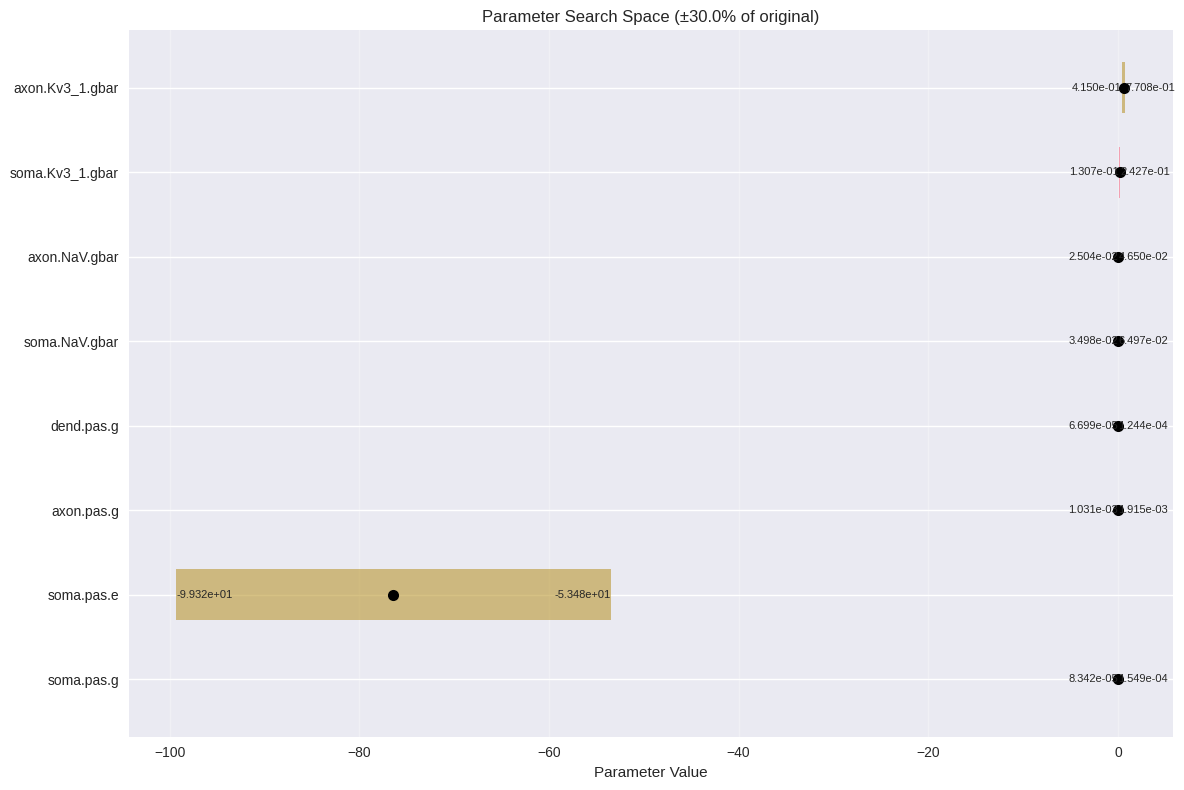

In [6]:
param_space.visualize()
plt.show()

## 2.7 Optimization loop

In [7]:
class OptimizationMonitor:
    """Monitor optimization progress"""
    
    def __init__(self):
        self.history = []
        self.best_fitness = -np.inf
        self.best_params = None
        self.best_metrics = None
        self.start_time = time.time()
        
    def callback(self, xk, convergence=None):
        """Optimizer callback function"""
        # This function is called at each iteration
        iteration = len(self.history)
        elapsed = time.time() - self.start_time
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}, elapsed time: {elapsed:.1f}s")
            
    def update(self, params, fitness, metrics):
        """Update history"""
        self.history.append({
            'iteration': len(self.history),
            'params': params.copy(),
            'fitness': fitness,
            'metrics': metrics.copy(),
            'time': time.time() - self.start_time
        })
        
        if fitness > self.best_fitness:
            self.best_fitness = fitness
            self.best_params = params.copy()
            self.best_metrics = metrics.copy()
            print(f"  🌟 New best! Fitness: {fitness:.4f}")
            
    def plot_progress(self):
        """Plot optimization progress"""
        if not self.history:
            return
            
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        iterations = [h['iteration'] for h in self.history]
        
        # 1. Fitness evolution
        ax = axes[0, 0]
        fitness_values = [h['fitness'] for h in self.history]
        ax.plot(iterations, fitness_values, 'b-', alpha=0.6)
        ax.scatter(iterations[-1], fitness_values[-1], c='red', s=100, zorder=5)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Fitness')
        ax.set_title('Fitness Evolution')
        ax.grid(True, alpha=0.3)
        
        # 2. Individual metrics evolution
        ax = axes[0, 1]
        metric_names = list(self.history[0]['metrics'].keys())
        for metric in metric_names:
            values = [h['metrics'][metric] for h in self.history]
            ax.plot(iterations, values, label=metric, alpha=0.7)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Metric Value')
        ax.set_title('Individual Metrics Evolution')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Parameter evolution heatmap
        ax = axes[1, 0]
        param_names = list(self.history[0]['params'].keys())[:8]  # Show first 8 parameters
        param_matrix = np.array([[h['params'][p] for p in param_names] 
                                for h in self.history]).T
        
        # Normalize
        param_matrix_norm = (param_matrix - param_matrix.min(axis=1, keepdims=True)) / \
                          (param_matrix.max(axis=1, keepdims=True) - 
                           param_matrix.min(axis=1, keepdims=True) + 1e-10)
        
        im = ax.imshow(param_matrix_norm, aspect='auto', cmap='viridis')
        ax.set_yticks(range(len(param_names)))
        ax.set_yticklabels([p.split('_')[-1] for p in param_names])
        ax.set_xlabel('Iteration')
        ax.set_title('Parameter Evolution (Normalized)')
        plt.colorbar(im, ax=ax)
        
        # 4. Computation time
        ax = axes[1, 1]
        times = [h['time'] for h in self.history]
        ax.plot(iterations, times, 'g-', linewidth=2)
        ax.set_xlabel('Iteration')
        ax.set_ylabel('Elapsed Time (s)')
        ax.set_title('Computation Time')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        return fig

## 2.8 Run optimization

In [ ]:
# Define objective function
def objective_function(x):
    """Optimization objective function"""
    try:
        # Convert parameters
        param_dict = param_space.vector_to_dict(x)
        
        # Run simulation
        time_data, voltage, n_spikes = optimizee.simulate(param_dict)
        
        # Evaluate fitness
        fitness, metrics = evaluator.evaluate(time_data, voltage, n_spikes)
        
        # Update monitor
        monitor.update(param_dict, fitness, metrics)
        
        # Return negative fitness (differential_evolution minimizes)
        return -fitness
        
    except Exception as e:
        logger.error(f"Simulation error: {e}")
        return 1e10  # Return large penalty value

# Create monitor
monitor = OptimizationMonitor()

# Run differential evolution optimization
print("Starting optimization...")
print(f"Parameter dimension: {len(param_space.bounds)}")
print(f"Population size: {15 * len(param_space.bounds)}")
print("\n")

result = differential_evolution(
    objective_function,
    param_space.bounds,
    strategy='best1bin',
    maxiter=50,  # Reduce iterations for faster demo
    popsize=15,
    tol=0.01,
    mutation=(0.5, 1),
    recombination=0.7,
    seed=42,
    disp=True,
    callback=monitor.callback,
    workers=1  # Can be set to -1 to use all CPU cores
)

print(f"\nOptimization complete!")
print(f"Best fitness: {-result.fun:.4f}")
print(f"Total evaluations: {result.nfev}")
print(f"Total time: {time.time() - monitor.start_time:.1f} seconds")

Starting optimization...
Parameter dimension: 8
Population size: 120


  🌟 New best! Fitness: -1.7497
  🌟 New best! Fitness: -1.4649
  🌟 New best! Fitness: -1.4456
  🌟 New best! Fitness: -1.4100
  🌟 New best! Fitness: -1.3854
  🌟 New best! Fitness: -1.3336


## 2.9 Analyze optimization results

In [ ]:
# Display optimization progress
monitor.plot_progress()
plt.show()

# Display best parameters
print("\nBest parameters (change relative to original):")
for key in param_space.parameters:
    original = param_space.parameters[key]['original']
    best = monitor.best_params[key]
    change = (best - original) / original * 100
    print(f"  {key}: {original:.3e} → {best:.3e} ({change:+.1f}%)")

print("\nBest metrics:")
for metric, value in monitor.best_metrics.items():
    print(f"  {metric}: {value:.4f}")

## 2.10 Visualize best fit results

In [ ]:
# Run simulation with best parameters
print("Running full simulation with best parameters...")
best_time, best_voltage, best_spikes = optimizee.simulate(monitor.best_params)

# Create detailed comparison figure
fig = evaluator.visualize_comparison(best_time, best_voltage, monitor.best_metrics)
plt.suptitle(f'Best Fit Results (Fitness: {monitor.best_fitness:.4f})', fontsize=16)
plt.show()

# Create final comparison plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot reference and best fit
ax.plot(ref_data.index, ref_data['U/mV'], 'k--', 
        linewidth=2.5, alpha=0.7, label='Reference Data')
ax.plot(best_time, best_voltage, 'b-', 
        linewidth=2, label='Best Fit')

# Add stimulus region
stim_start = stimulus['delay']
stim_end = stimulus['delay'] + stimulus['duration']
ax.axvspan(stim_start, stim_end, alpha=0.15, color='gray', label='Stimulus')

# Mark spikes
peaks, _ = signal.find_peaks(best_voltage, height=-10, distance=50)
if len(peaks) > 0:
    ax.plot(best_time[peaks], best_voltage[peaks], 'ro', 
           markersize=8, label=f'Spikes (n={len(peaks)})')

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Membrane Potential (mV)', fontsize=12)
ax.set_title('Optimized Model vs Reference Data', fontsize=14)
ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3)

# Add text information
info_text = f"MSE: {-monitor.best_metrics['mse']*1000:.2f} mV²\n"
info_text += f"Correlation: {monitor.best_metrics['shape']:.3f}\n"
info_text += f"Spike Count: {best_spikes} (ref: {evaluator.ref_spike_count})"
ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
        verticalalignment='top', bbox=dict(boxstyle='round', 
        facecolor='wheat', alpha=0.5), fontsize=10)

plt.tight_layout()
plt.show()